<a href="https://colab.research.google.com/github/jonbaer/googlecolab/blob/master/TF_IDF_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TF-IDF** can be seen as a function that ranks words based on their importance accross documents, weighted down by the amout of times they actually appear, following the idea that if a word is way too common, it shouldn't be that important.

Mathematically, it is the equivalent of calculating the _term frequency_ (TF) multiplied by the _inverse document frequency_ (IDF). So, given a term _t_ and a document _d_. For our `TF` we'd have:

$$TF(t,d) = \frac{count(t,d)}{count(*,d)}$$

Where `count(t,d)` is the amount of times `t` appears inside of `d`, and `count(*,d)` is the total number of terms inside of `d`, meaning that, if a word appears a lot in our documents, that means that it's probably somewhat revelant.

But, what about words that are actually common but don't bring any value for us? That's where IDF comes in, it's a way to weight down such common words by comparing its appearance among all of our documents. So, if a word appears way too much across many documents, it probably means that it isn't that relevant and it's just a common word. Here's what it looks like in maths language:

$$IDF(t,D) = log_e(\frac{D}{amount(t,D)})$$

Where `D` is the total number of documents, and `amount(t,D)` is the number of documents containing `t`.
The $log_e$ is due to the fact that the `IDF` would explode for the cases where we have too many documents.

Finally, we have:

$$TF\text{-}IDF = TF(t,d)*IDF(t,D)$$

Here we'll learn how to implement and make proper use of it

Before anything, let's get the raw dataset that we'll work on from [BBC](http://mlg.ucd.ie/datasets/bbc.html):

In [0]:
!wget http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip
!unzip -fq bbc-fulltext.zip
!rm bbc-fulltext.zip*
%cd bbc
!rm README.TXT

--2019-12-31 07:38:47--  http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip
Resolving mlg.ucd.ie (mlg.ucd.ie)... 137.43.93.132
Connecting to mlg.ucd.ie (mlg.ucd.ie)|137.43.93.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874078 (2.7M) [application/zip]
Saving to: ‘bbc-fulltext.zip’

bbc-fulltext.zip    100%[===================>]   2.74M  2.70MB/s    in 1.0s    

2019-12-31 07:38:49 (2.70 MB/s) - ‘bbc-fulltext.zip’ saved [2874078/2874078]

replace bbc/business/001.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace bbc/business/002.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
/content/bbc


Then do some imports so we can actually work on our data:

In [0]:
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from collections import Counter
import pandas as pd
import numpy as np
import nltk
import re
import os

In [0]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

See that `SnowballStemmer` and `WordNetLemmatizer` over there? We'll talk about those latter on. For now, we'll begin by reading all of the data into our program

In [0]:
documents = []
for root, dirs, files in os.walk("."):
    for name in files:
        if name.endswith((".txt")):
            filepath = root + os.sep + name
            with open(filepath, 'r', encoding='latin-1') as file:
                data = file.read().replace('\n', ' ').split()
                documents.append(data)

Now it's time to actually preprocess our data. We'll first remove all characters with a length of 1, since those don't bring any useful information to us.

In [0]:
documents = [[word for word in sublist if (len(word)>1)]
             for sublist in documents]

We're also gonna make all words lowercase, since a computer thinks that "*Word*" is not the same as "*word*", due to the value of an uppercase letter being different from a lowercase one.

In [0]:
documents = [[word.lower() for word in sublist]
             for sublist in documents]

Remove all of the meaningless symbols

In [0]:
symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\'"
for i in symbols:
    documents = [[''.join([char for char in word if char != i])
                  for word in sublist]
                  for sublist in documents]

Let's make use of `nltk` in order to detect our stopwords, words that won't have any relevance for our needs, such as *is*, *you*, *when*, and then remove those.

In [0]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")
documents = [[word for word in sublist if word not in stopwords]
             for sublist in documents]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Remember those `nlkt.stem` libraries we imported earlier? Those are responsible for the stemming and lemmatization of our dataset. But what are those things? 

Simply put, stemming is the process of simply "cutting" a word from any sufix or prefix to get its radical (e.g., *studying* would become *study*, while *studies* would become *studi*). On the other hand, lemmatization is a process a bit more complicated, where we would go through some morphological analysis in order to get back our "root" word(e.g., *better* would become *good*).

You can read more about it [here](https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/).

Let's go with lemmatization and then stemming because it's fancier, but ideally you should experiment with each one seperatedly and then together to see which strategy would be the best fit for your data while considering the time it takes to run.

In [0]:
lemmatizer = WordNetLemmatizer()
documents = [[lemmatizer.lemmatize(word) for word in sublist]
             for sublist in documents]

stemmer = SnowballStemmer('english')
documents = [[stemmer.stem(word) for word in sublist]
             for sublist in documents]

Basically, what we've done so far was:

- Removing characters with length equal to 1
- Making everything lowercase
- Removing symbols
- Removing stopwords
- Lemmatizing then stemming every word in our corpus.

So, everything looks ready to go, let's finally get into processing our data! We'll start off by simply getting the document frequency for each word in each document



In [0]:
dfs = {}
for i in range(len(documents)):
    for word in documents[i]:
        try:
            dfs[word].add(i)
        except:
            dfs[word] = {i}

One nice thing to note is that the length of `dfs` is actually the total amout of unique words we have

In [0]:
len(dfs)

32679

Now, `dfs` actually has a list of each document that contains a specific word, but we don't need that. Instead, what we need is simply the amount of documents containing the word, so let's fix this up

In [0]:
for i in dfs:
    dfs[i] = len(dfs[i])

We can finally make ourselves a dictionary containing the tf-idf score for each word in each document

In [0]:
tf_idf = {}
for i in range(len(documents)):
    counter = Counter(documents[i])
    for token in np.unique(documents[i]):
        tf = counter[token]/len(documents[i])
        df = dfs[token]
        idf = np.log(len(documents)/(df+1))
        tf_idf[i, token] = tf*idf

And convert it into a `DataFrame` to make it easier to toy with it.

In [0]:
(pd.DataFrame(list(tf_idf.items()))
    .sort_values(by=[1], ascending=False)
    .head(5))

,0,1
295153,"(1866, godzilla)",0.523006
194078,"(1231, rugby,)",0.515184
74828,"(521, commodor)",0.492562
147065,"(896, commodor)",0.492562
212216,"(1367, pountney)",0.483578


We can also create a word cloud for a nice visualization of our data!

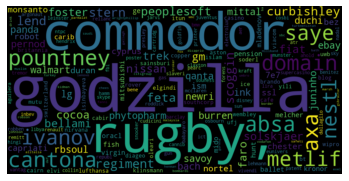

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
% matplotlib inline

word_cloud_dict = {}
for key, val in tf_idf.items():
    if key[1] not in word_cloud_dict or val > word_cloud_dict[key[1]]:
        word_cloud_dict[key[1]] = val

wordcloud = WordCloud().generate_from_frequencies(word_cloud_dict)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

And even create a word cloud for some specific document

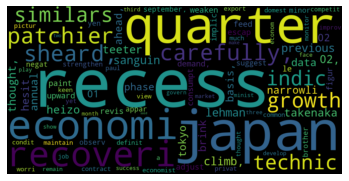

In [0]:
word_cloud_dict = {(key[1] if key[0]==1 else "a"):(val) for (key,val) in tf_idf.items()}

wordcloud = WordCloud().generate_from_frequencies(word_cloud_dict)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Resources that I used to write this:

http://www.tfidf.com

https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76

https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089

https://cloud.google.com/blog/products/gcp/problem-solving-with-ml-automatic-document-classification

https://www.datacamp.com/community/tutorials/stemming-lemmatization-python

